In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import keras_hub

train_dir = "/kaggle/input/alzheimer-disease-dataset/Alzheimer_Dataset_V2/train"
val_dir = "/kaggle/input/alzheimer-disease-dataset/Alzheimer_Dataset_V2/val"
test_dir = "/kaggle/input/alzheimer-disease-dataset/Alzheimer_Dataset_V2/test"

img_size = (180, 180)
batch_size = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_dataset.map(lambda x, y: (normalization_layer(x), y))

2025-09-17 14:53:12.606614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758120792.782661      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758120792.834777      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 23788 files belonging to 4 classes.


I0000 00:00:1758120813.105468      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758120813.106144      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5097 files belonging to 4 classes.
Found 5099 files belonging to 4 classes.


In [2]:
for data_batch, labels_batch in train_ds:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32, 4)


In [3]:
# Simple CNN

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=keras.optimizers.AdamW(learning_rate=1e-5),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint("simple_conv2d.keras",
                                   save_best_only=True,
                                   monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                     factor=0.2,
                                     patience=3,
                                     min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                 patience=5,
                                 restore_best_weights=True)
]

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 215168)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       860,676 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 953,924 (3.64 MB)

 Trainable params: 953,924 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/50


I0000 00:00:1758033182.829333     108 service.cc:148] XLA service 0x7bcf5808e040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758033182.830708     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758033182.830727     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758033183.230144     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/744 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.2307 - loss: 1.3907

I0000 00:00:1758033187.883602     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


744/744 ━━━━━━━━━━━━━━━━━━━━ 75s 91ms/step - accuracy: 0.3584 - loss: 1.3136 - val_accuracy: 0.5136 - val_loss: 1.1355 - learning_rate: 1.0000e-05
Epoch 2/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.5474 - loss: 1.0780 - val_accuracy: 0.5370 - val_loss: 1.0326 - learning_rate: 1.0000e-05
Epoch 3/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.5947 - loss: 0.9604 - val_accuracy: 0.5805 - val_loss: 0.9391 - learning_rate: 1.0000e-05
Epoch 4/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.6186 - loss: 0.8984 - val_accuracy: 0.6221 - val_loss: 0.8721 - learning_rate: 1.0000e-05
Epoch 5/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.6411 - loss: 0.8523 - val_accuracy: 0.6327 - val_loss: 0.8468 - learning_rate: 1.0000e-05
Epoch 6/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.6572 - loss: 0.8164 - val_accuracy: 0.6549 - val_loss: 0.8253 - learning_rate: 1.0000e-05
Epoch 7/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accurac

In [5]:
model = keras.models.load_model("simple_conv2d.keras")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test_accuracy: {test_acc:.3f}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.7945 - loss: 0.5303
Test_accuracy: 0.796


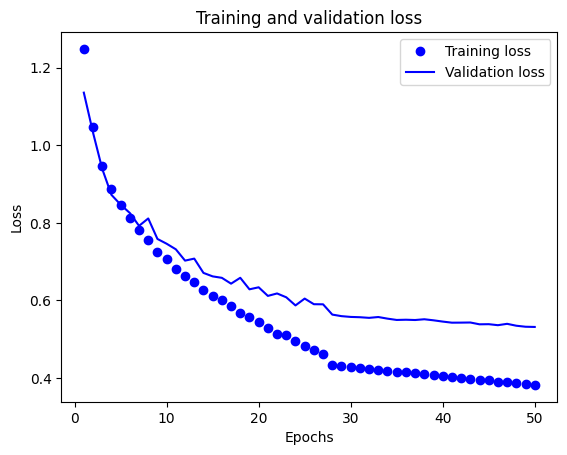

In [6]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

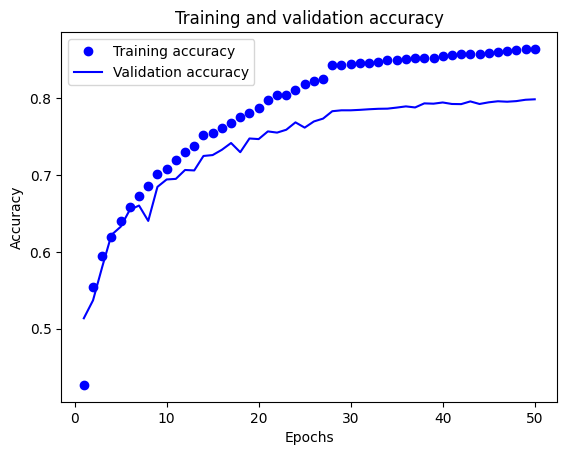

In [7]:
history_dict = history.history
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, "bo", label="Training accuracy")
plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [8]:
# A little bit more complex CNN

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │        50,180 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,676 (3.92 MB)

 Trainable params: 1,028,676 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=1e-5),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="simplev2_conv2d.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                     factor=0.2,
                                     patience=3,
                                     min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                 patience=5,
                                 restore_best_weights=True)
]

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=callbacks,
)

Epoch 1/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.3119 - loss: 1.3624 - val_accuracy: 0.3955 - val_loss: 1.2453 - learning_rate: 1.0000e-05
Epoch 2/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.4624 - loss: 1.2132 - val_accuracy: 0.5423 - val_loss: 1.0998 - learning_rate: 1.0000e-05
Epoch 3/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.5520 - loss: 1.0646 - val_accuracy: 0.5937 - val_loss: 0.9717 - learning_rate: 1.0000e-05
Epoch 4/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.6078 - loss: 0.9280 - val_accuracy: 0.6321 - val_loss: 0.8672 - learning_rate: 1.0000e-05
Epoch 5/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.6387 - loss: 0.8453 - val_accuracy: 0.6382 - val_loss: 0.8216 - learning_rate: 1.0000e-05
Epoch 6/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.6611 - loss: 0.7916 - val_accuracy: 0.6545 - val_loss: 0.7770 - learning_rate: 1.0000e-05
Epoch 7/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/ste

KeyboardInterrupt: 

In [11]:
model = keras.models.load_model("simplev2_conv2d.keras")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test_accuracy: {test_acc:.3f}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8694 - loss: 0.3452
Test_accuracy: 0.878


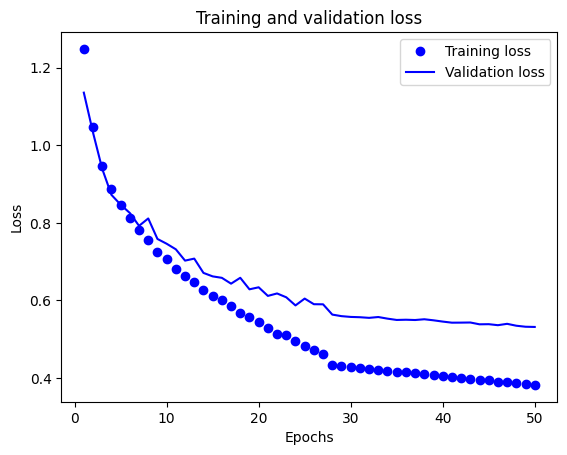

In [12]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

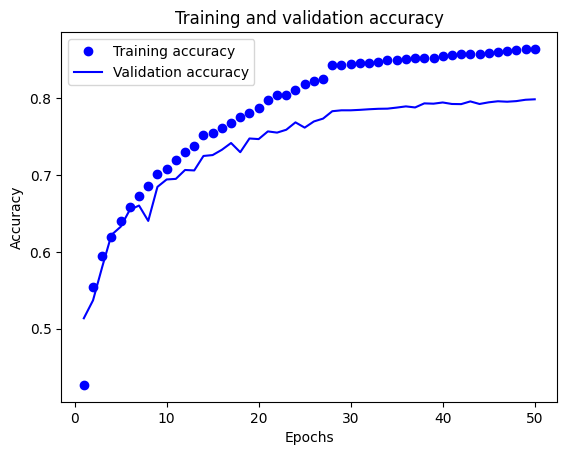

In [13]:
history_dict = history.history
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, "bo", label="Training accuracy")
plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
# CNN with BatchNormalization & Dropout

inputs = keras.Input(shape=(180, 180, 3))

x = layers.Conv2D(filters=32, kernel_size=3)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 178, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 41, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,408,580 (28.26 MB)

 Trainable params: 7,406,084 (28.25 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [15]:
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=1e-4),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="complex_conv2d.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                     factor=0.2,
                                     patience=3,
                                     min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                 patience=5,
                                 restore_best_weights=True)
]

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=callbacks,
)

Epoch 1/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - accuracy: 0.5665 - loss: 1.1693 - val_accuracy: 0.7479 - val_loss: 0.6066 - learning_rate: 1.0000e-04
Epoch 2/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.7906 - loss: 0.5371 - val_accuracy: 0.8148 - val_loss: 0.4857 - learning_rate: 1.0000e-04
Epoch 3/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - accuracy: 0.8743 - loss: 0.3279 - val_accuracy: 0.8788 - val_loss: 0.3231 - learning_rate: 1.0000e-04
Epoch 4/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.9153 - loss: 0.2281 - val_accuracy: 0.8962 - val_loss: 0.2702 - learning_rate: 1.0000e-04
Epoch 5/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.9436 - loss: 0.1558 - val_accuracy: 0.9019 - val_loss: 0.2643 - learning_rate: 1.0000e-04
Epoch 6/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9565 - loss: 0.1181 - val_accuracy: 0.9027 - val_loss: 0.2956 - learning_rate: 1.0000e-04
Epoch 7/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/ste

In [16]:
model = keras.models.load_model("/kaggle/working/complex_conv2d.keras")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test_accuracy: {test_acc:.3f}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9310 - loss: 0.2098
Test_accuracy: 0.930


In [17]:
# Xception body + classification head

conv_base = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

conv_base.trainable = False

inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.xception.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="feature_extraction.keras",
                                   save_best_only=True,
                                   monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                     factor=0.2,
                                     patience=3,
                                     min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                 patience=5,
                                 restore_best_weights=True)
]

history = model.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset,
                   callbacks=callbacks)

Epoch 1/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 103s 118ms/step - accuracy: 0.4784 - loss: 1.1298 - val_accuracy: 0.6382 - val_loss: 0.8562 - learning_rate: 1.0000e-04
Epoch 2/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 77s 103ms/step - accuracy: 0.6254 - loss: 0.8543 - val_accuracy: 0.6498 - val_loss: 0.7820 - learning_rate: 1.0000e-04
Epoch 3/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 77s 103ms/step - accuracy: 0.6564 - loss: 0.7776 - val_accuracy: 0.6778 - val_loss: 0.7361 - learning_rate: 1.0000e-04
Epoch 4/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 77s 103ms/step - accuracy: 0.6829 - loss: 0.7290 - val_accuracy: 0.7014 - val_loss: 0.6983 - learning_rate: 1.0000e-04
Epoch 5/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 76s 102ms/step - accuracy: 0.7003 - loss: 0.6888 - val_accuracy: 0.7118 - val_loss: 0.6786 - learning_rate: 1.0000e-04
Epoch 6/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 76s 102ms/step - accuracy: 0.7141 - loss: 0.6601 - val_accuracy: 0.7169 - val_loss: 0.6524 - learning_rate: 1.0000e-04
Epoch 7/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 77s 1

In [2]:
model = keras.models.load_model("/kaggle/input/xception_new_head/tensorflow2/default/1/xception_new_head.keras")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

I0000 00:00:1758042308.786781     108 service.cc:148] XLA service 0x7f76e0039bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758042308.787470     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758042308.787492     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758042309.311723     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/160 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.8750 - loss: 0.4081 

I0000 00:00:1758042315.282796     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.8632 - loss: 0.3518
Test acc: 0.863


In [3]:
# Unfreezing xception last 30 layers + classification head

trainable_params_before = sum(tf.size(w).numpy() for w in model.trainable_weights)
print(trainable_params_before)

conv_base = model.get_layer("xception")

conv_base.trainable = True

for layer in conv_base.layers[:-30]:
    layer.trainable = False

525572


In [4]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="finetune.keras",
                                   save_best_only=True,
                                   monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                     factor=0.2,
                                     patience=3,
                                     min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                 patience=5,
                                 restore_best_weights=True)
]

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 6, 6, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,387,052 (81.59 MB)

 Trainable params: 9,465,924 (36.11 MB)

 Non-trainable params: 11,921,128 (45.48 MB)

In [5]:
initial_epochs = 50
fine_tune_epochs = 15

total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
)

Epoch 51/65


E0000 00:00:1758042416.922567     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758042417.059403     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


744/744 ━━━━━━━━━━━━━━━━━━━━ 155s 180ms/step - accuracy: 0.6808 - loss: 0.8365 - val_accuracy: 0.8448 - val_loss: 0.3701 - learning_rate: 1.0000e-04
Epoch 52/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 128s 172ms/step - accuracy: 0.9139 - loss: 0.2302 - val_accuracy: 0.8962 - val_loss: 0.2913 - learning_rate: 1.0000e-04
Epoch 53/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 128s 173ms/step - accuracy: 0.9625 - loss: 0.1053 - val_accuracy: 0.9147 - val_loss: 0.2282 - learning_rate: 1.0000e-04
Epoch 54/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 128s 172ms/step - accuracy: 0.9751 - loss: 0.0658 - val_accuracy: 0.9488 - val_loss: 0.1598 - learning_rate: 1.0000e-04
Epoch 55/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 128s 172ms/step - accuracy: 0.9833 - loss: 0.0470 - val_accuracy: 0.9537 - val_loss: 0.1492 - learning_rate: 1.0000e-04
Epoch 56/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 128s 172ms/step - accuracy: 0.9869 - loss: 0.0398 - val_accuracy: 0.9647 - val_loss: 0.1110 - learning_rate: 1.0000e-04
Epoch 57/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 127s 

In [6]:
model = keras.models.load_model("/kaggle/working/finetune.keras")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9750 - loss: 0.0912
Test acc: 0.978


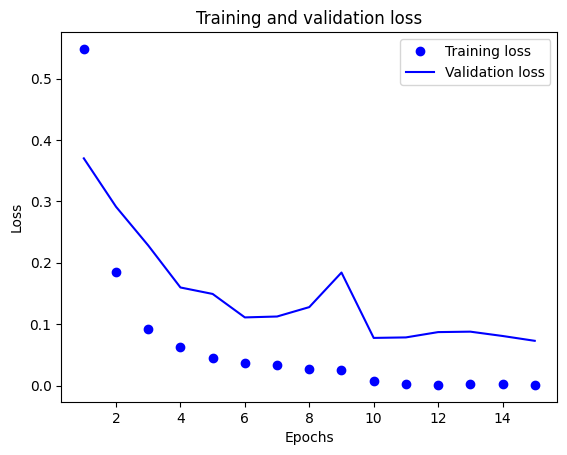

In [8]:
history_dict = history_fine_tune.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

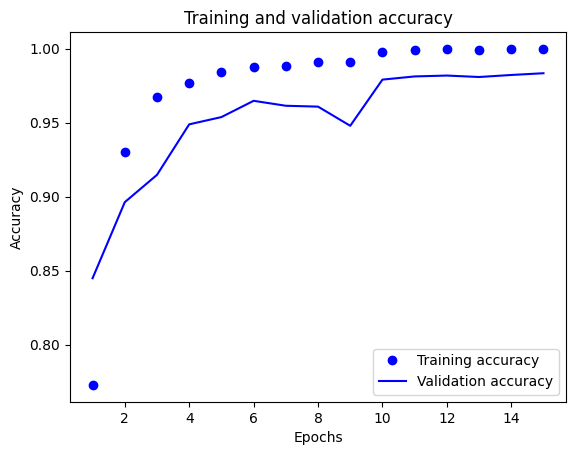

In [9]:
history_dict = history_fine_tune.history
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, "bo", label="Training accuracy")
plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [2]:
efficientnetbasev2s = keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(180, 180, 3),
)

efficientnetbasev2s.trainable = False

inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.efficientnet_v2.preprocess_input(inputs)
x = efficientnetbasev2s(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 6, 6, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,660,324 (78.81 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [3]:
model.compile(optimizer=keras.optimizers.AdamW(1e-4),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="efficientnetv2s.keras",
                                   save_best_only=True,
                                   monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                     factor=0.2,
                                     patience=3,
                                     min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                 patience=5,
                                 restore_best_weights=True)
]

history = model.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset,
                   callbacks=callbacks)

Epoch 1/50


I0000 00:00:1758051754.916830     108 service.cc:148] XLA service 0x7e4fb00a04f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758051754.918349     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758051754.918373     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758051758.760538     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/744 ━━━━━━━━━━━━━━━━━━━━ 1:04 87ms/step - accuracy: 0.3047 - loss: 1.6276   

I0000 00:00:1758051779.143055     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


744/744 ━━━━━━━━━━━━━━━━━━━━ 152s 127ms/step - accuracy: 0.4275 - loss: 1.2327 - val_accuracy: 0.6035 - val_loss: 0.9292 - learning_rate: 1.0000e-04
Epoch 2/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 60s 81ms/step - accuracy: 0.5618 - loss: 0.9938 - val_accuracy: 0.6306 - val_loss: 0.8466 - learning_rate: 1.0000e-04
Epoch 3/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.5979 - loss: 0.9178 - val_accuracy: 0.6541 - val_loss: 0.7915 - learning_rate: 1.0000e-04
Epoch 4/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 59s 79ms/step - accuracy: 0.6223 - loss: 0.8646 - val_accuracy: 0.6735 - val_loss: 0.7516 - learning_rate: 1.0000e-04
Epoch 5/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 59s 79ms/step - accuracy: 0.6279 - loss: 0.8314 - val_accuracy: 0.6859 - val_loss: 0.7246 - learning_rate: 1.0000e-04
Epoch 6/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 59s 79ms/step - accuracy: 0.6557 - loss: 0.7966 - val_accuracy: 0.6963 - val_loss: 0.7071 - learning_rate: 1.0000e-04
Epoch 7/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 59s 79ms/step - accur

In [4]:
model = keras.models.load_model("/kaggle/working/efficientnetv2s.keras")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.8566 - loss: 0.3835
Test acc: 0.859


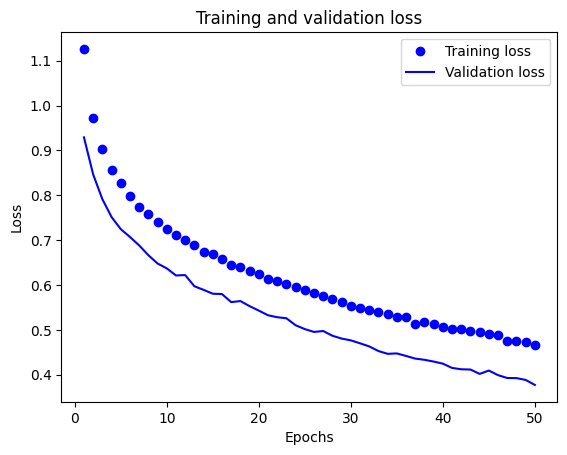

In [5]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

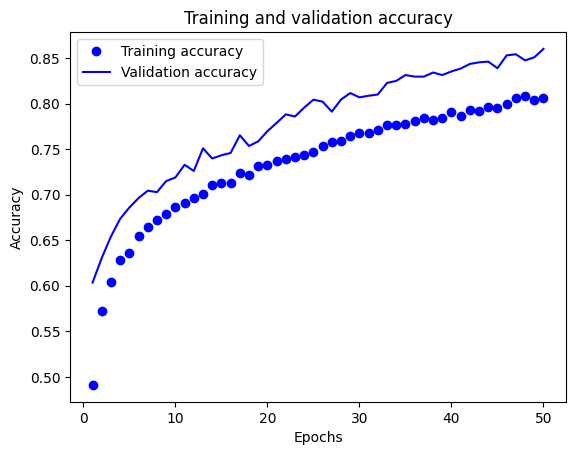

In [6]:
history_dict = history.history
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, "bo", label="Training accuracy")
plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [7]:
# Unfreezing EfficientNetV2S last 30 layers + classification head

trainable_params_before = sum(tf.size(w).numpy() for w in model.trainable_weights)
print(trainable_params_before)

efficientnetbasev2s = model.get_layer("efficientnetv2-s")

efficientnetbasev2s.trainable = True

for layer in efficientnetbasev2s.layers[:-30]:
    layer.trainable = False

328964


In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="efficientnetv2s_fine_tuned.keras",
                                   save_best_only=True,
                                   monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                     factor=0.2,
                                     patience=3,
                                     min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                 patience=5,
                                 restore_best_weights=True)
]

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 6, 6, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,660,324 (78.81 MB)

 Trainable params: 2,273,156 (8.67 MB)

 Non-trainable params: 18,387,168 (70.14 MB)

In [9]:
initial_epochs = 50
fine_tune_epochs = 15

total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
)

Epoch 51/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 166s 139ms/step - accuracy: 0.7346 - loss: 0.6708 - val_accuracy: 0.8707 - val_loss: 0.3345 - learning_rate: 1.0000e-04
Epoch 52/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 65s 87ms/step - accuracy: 0.8108 - loss: 0.4542 - val_accuracy: 0.8944 - val_loss: 0.2801 - learning_rate: 1.0000e-04
Epoch 53/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - accuracy: 0.8432 - loss: 0.3866 - val_accuracy: 0.9054 - val_loss: 0.2438 - learning_rate: 1.0000e-04
Epoch 54/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - accuracy: 0.8645 - loss: 0.3309 - val_accuracy: 0.9286 - val_loss: 0.1899 - learning_rate: 1.0000e-04
Epoch 55/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - accuracy: 0.8855 - loss: 0.2851 - val_accuracy: 0.9462 - val_loss: 0.1558 - learning_rate: 1.0000e-04
Epoch 56/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - accuracy: 0.9044 - loss: 0.2438 - val_accuracy: 0.9570 - val_loss: 0.1243 - learning_rate: 1.0000e-04
Epoch 57/65
744/744 ━━━━━━━━━━━━━━━━━━━━ 62s

In [11]:
initial_epochs = 65
fine_tune_epochs = 10

total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
)

Epoch 66/75
744/744 ━━━━━━━━━━━━━━━━━━━━ 135s 124ms/step - accuracy: 0.9562 - loss: 0.1199 - val_accuracy: 0.9800 - val_loss: 0.0570 - learning_rate: 1.0000e-04
Epoch 67/75
744/744 ━━━━━━━━━━━━━━━━━━━━ 63s 85ms/step - accuracy: 0.9610 - loss: 0.1064 - val_accuracy: 0.9757 - val_loss: 0.0685 - learning_rate: 1.0000e-04
Epoch 68/75
744/744 ━━━━━━━━━━━━━━━━━━━━ 64s 86ms/step - accuracy: 0.9616 - loss: 0.1065 - val_accuracy: 0.9818 - val_loss: 0.0510 - learning_rate: 1.0000e-04
Epoch 69/75
744/744 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.9626 - loss: 0.1041 - val_accuracy: 0.9808 - val_loss: 0.0534 - learning_rate: 1.0000e-04
Epoch 70/75
744/744 ━━━━━━━━━━━━━━━━━━━━ 64s 87ms/step - accuracy: 0.9646 - loss: 0.0980 - val_accuracy: 0.9837 - val_loss: 0.0487 - learning_rate: 1.0000e-04
Epoch 71/75
744/744 ━━━━━━━━━━━━━━━━━━━━ 63s 84ms/step - accuracy: 0.9618 - loss: 0.0994 - val_accuracy: 0.9804 - val_loss: 0.0507 - learning_rate: 1.0000e-04
Epoch 72/75
744/744 ━━━━━━━━━━━━━━━━━━━━ 64s

In [12]:
model = keras.models.load_model("/kaggle/working/efficientnetv2s_fine_tuned.keras")
print(f"Test acc: {model.evaluate(test_dataset)[1]:.3f}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 30s 87ms/step - accuracy: 0.9868 - loss: 0.0409
Test acc: 0.986


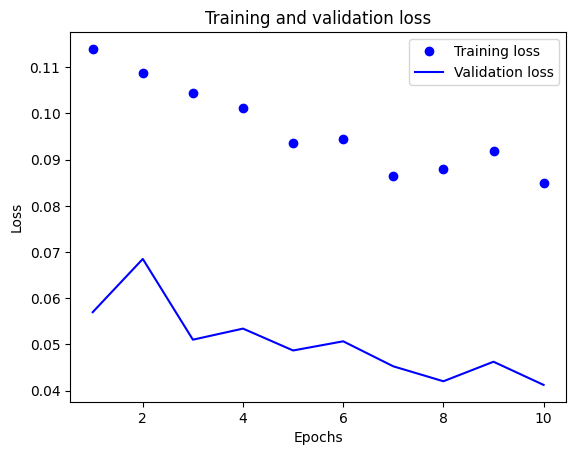

In [14]:
history_dict = history_fine_tune.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

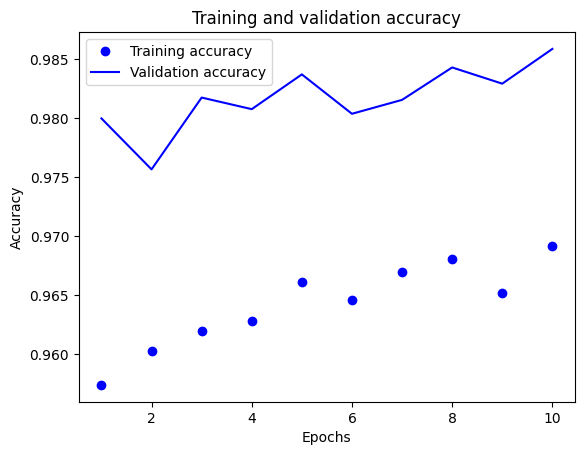

In [15]:
history_dict = history_fine_tune.history
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, "bo", label="Training accuracy")
plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()